# Dependencies

In [ ]:
!pip install wikidata_plain_sparql

In [ ]:
import wikidata_plain_sparql as wikidata
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import math

# Pengambilan Data

In [ ]:
df = wikidata.query('''
SELECT ?dramaLabel ?artistLabel
WHERE{
  ?a wdt:P31 wd:Q5398426; 
     wdt:P495 wd:Q884; 
     rdfs:label ?dramaLabel;
     wdt:P161 ?b .
  ?b rdfs:label ?artistLabel;
  MINUS{?a wdt:P136 wd:Q182415 .}
  FILTER(LANG(?dramaLabel) = "en")
  FILTER(LANG(?artistLabel) = "en")
}
''')

In [ ]:
df

,dramaLabel,artistLabel
0,Faith,Lee Min Ho
1,Dae Jang Geum,Yang Mi-kyung
2,Dae Jang Geum,Hong Ri-na
3,Dae Jang Geum,Im Ho
4,Dae Jang Geum,Ji Jin-hee
...,...,...
2841,Childless Comfort,Lee Soon-jae
2842,Cheongdam-dong Alice,So I-hyeon
2843,Cheongdam-dong Alice,Kim Ji-seok
2844,Cheongdam-dong Alice,Park Shi-hoo


In [ ]:
artistName = list(set(df['artistLabel']))
dramaName = list(set(df['dramaLabel']))

In [ ]:
len(artistName)

1317

# Visualisasi graph

In [ ]:
dramaAndArtis = {}
for i in dramaName:
  dramaAndArtis[i] = []

for index, row in df.iterrows():
  tmp = dramaAndArtis[row['dramaLabel']]
  tmp.append(row['artistLabel'])
  dramaAndArtis[row['dramaLabel']] = tmp

In [ ]:
# Adjecency List
graphArtis = {}

for i in artistName:
  a = df[df['artistLabel'] == i]
  tmp = []
  for j in a['dramaLabel']:
    tmp = tmp + dramaAndArtis[j]
  coStaring = list(set(tmp))
  coStaring.remove(i)
  graphArtis[i] = coStaring

In [ ]:
# capture nodes in 2 separate lists
node_list_1 = []
node_list_2 = []
for i in (graphArtis):
  for j in (graphArtis[i]):
    node_list_1.append(i)
    node_list_2.append(j)

artis_edge = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

In [ ]:
artis_edge

,node_1,node_2
0,Ryu Soo-young,Ji Seong
1,Ryu Soo-young,Lee Bo-yeong
2,Ryu Soo-young,Eugene
3,Kim So-gjong,Kim Seon-ho
4,Kim So-gjong,Lee Jae-Won
...,...,...
27733,Im Chul-soo,Yoon Bok-in
27734,Im Chul-soo,Yoon Byung-hee
27735,Im Chul-soo,Choi Young-joon
27736,Im Chul-soo,Jo Han-chul


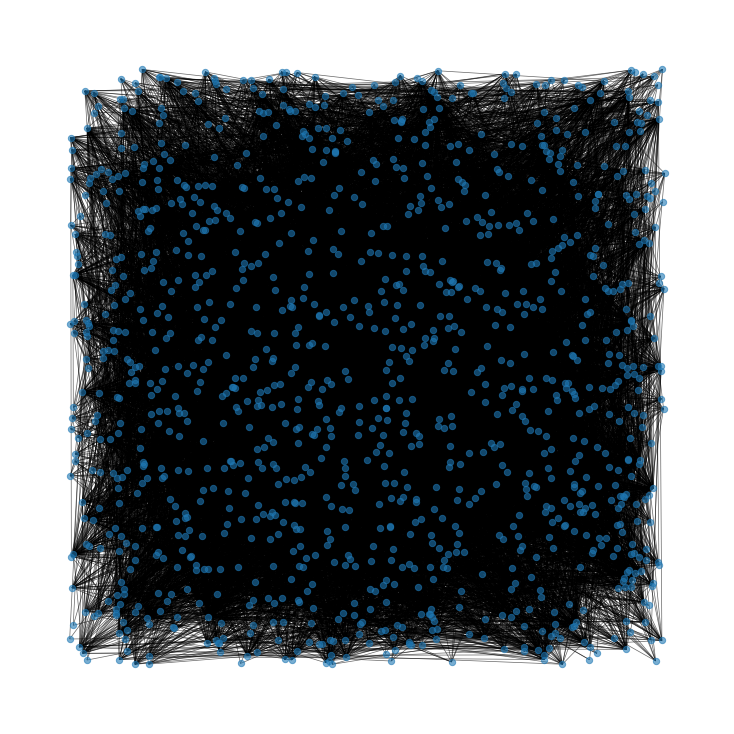

In [ ]:
# create graph
G = nx.from_pandas_edgelist(artis_edge, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [ ]:
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

In [ ]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
for i in tqdm(range(adj_G.shape[0])):
  for j in range(0,i):
    if adj_G[i,j] == 0:
      all_unconnected_pairs.append([node_list[i],node_list[j]])

100%|██████████| 1230/1230 [00:02<00:00, 564.39it/s]


In [ ]:
len(list(G.edges))

13869

In [ ]:
len(all_unconnected_pairs)

741966

In [ ]:
len(list(G.nodes))

1230

# Node Neighborhood-based Method

##  Common Neighbors

In [ ]:
def commonNeighbors(A,B):
  neighborsA = list(G.neighbors(A))
  neighborsB = list(G.neighbors(B))
  intersection = set(neighborsA) & set(neighborsB)
  return len(intersection)

In [ ]:
score_common = {}
for i in all_unconnected_pairs:
  tmp = commonNeighbors(i[0],i[1])
  score_common[i[0] + ' - ' + i[1]] = tmp

In [ ]:
score = pd.DataFrame(score_common.items(), columns=['Edge', 'Score'])

In [ ]:
scoreFinalCommon = score.sort_values(by='Score', ascending=False).reset_index(drop=True)

In [ ]:
scoreFinalCommon.head(50)

,Edge,Score
0,Um Hyo-sup - Kang Sin-il,20
1,Yoo Yeon-seok - Choi Woong,16
2,Im Se-mi - Choi Woong,16
3,Kim Soo-hyun - Chun Jung-myung,16
4,Choi Woong - Kim Dong-gyun,15
5,Chun Jung-myung - Kim Chang-wan,15
6,Jeong Man-sik - Um Hyo-sup,15
7,Kim Hee-won - Kang Sin-il,14
8,Moon Chae-won - Yoo In-na,14
9,Jo Jung-suk - Um Hyo-sup,14


## Jaccard Similarity

In [ ]:
def jaccardSimilarity(A,B):
  neighborsA = list(G.neighbors(A))
  neighborsB = list(G.neighbors(B))
  intersection = set(neighborsA) & set(neighborsB)
  union = set(neighborsA) | set(neighborsB)
  jaccScore = len(intersection) / len(union)
  return jaccScore

In [ ]:
score_jaccard = {}
for i in all_unconnected_pairs:
  tmp = jaccardSimilarity(i[0],i[1])
  score_jaccard[i[0] + ' - ' + i[1]] = tmp

In [ ]:
score = pd.DataFrame(score_jaccard.items(), columns=['Edge', 'Score'])

In [ ]:
scoreFinalJaccard = score.sort_values(by='Score', ascending=False).reset_index(drop=True)

In [ ]:
scoreFinalJaccard.head(50)

,Edge,Score
0,Nam Sang-mi - Baek Jin-hee,0.333333
1,Cha Hwa-yeon - Kim Yu-mi,0.333333
2,Lee Yeong-ho - Ahn Jae-mo,0.250000
3,Jun Hyo-seong - Eric Mun,0.250000
4,Jeon Mi-do - Baek Jin-hee,0.250000
5,Seo Hyun-woo - Lee Sun-bin,0.250000
6,Kim Seong-su - Won Bin,0.250000
7,Jun Hyun-moo - Cho Kyuhyun,0.250000
8,Ma Dong-seok - Jang Shin-young,0.250000
9,Jang Jin-young - Chae Rim,0.250000


## Adamic and Adar Measure

In [ ]:
def adamicAdar(A,B):
  neighborsA = list(G.neighbors(A))
  neighborsB = list(G.neighbors(B))
  intersection = set(neighborsA) & set(neighborsB)
  score = 0
  for i in intersection:
    tmp = 1/math.log(len(list(G.neighbors(i))))
    score = score + tmp
  return score

In [ ]:
score_adamadar = {}
for i in all_unconnected_pairs:
  tmp = adamicAdar(i[0],i[1])
  score_adamadar[i[0] + ' - ' + i[1]] = tmp

In [ ]:
score = pd.DataFrame(score_adamadar.items(), columns=['Edge', 'Score'])

In [ ]:
scoreFinalAdamadar = score.sort_values(by='Score', ascending=False).reset_index(drop=True)

In [ ]:
scoreFinalAdamadar.head(10)

,Edge,Score
0,Um Hyo-sup - Kang Sin-il,4.762552
1,Im Se-mi - Choi Woong,3.960515
2,Kim Soo-hyun - Chun Jung-myung,3.832310
3,Yoo Yeon-seok - Choi Woong,3.734029
4,Jeong Man-sik - Um Hyo-sup,3.633643
5,Chun Jung-myung - Kim Chang-wan,3.575241
6,Choi Woong - Kim Dong-gyun,3.513405
7,Chun Jung-myung - Moon Chae-won,3.509008
8,Moon Chae-won - Yoo In-na,3.482441
9,Moon Chae-won - Daniel L,3.470074


## Preferential Attachment

In [ ]:
def preferential(A,B):
  neighborsA = len(list(G.neighbors(A)))
  neighborsB = len(list(G.neighbors(B)))
  return neighborsA * neighborsB

In [ ]:
score_preferential = {}
for i in all_unconnected_pairs:
  tmp = preferential(i[0],i[1])
  score_preferential[i[0] + ' - ' + i[1]] = tmp

In [ ]:
score = pd.DataFrame(score_preferential.items(), columns=['Edge', 'Score'])

In [ ]:
scoreFinalPreferential = score.sort_values(by='Score', ascending=False).reset_index(drop=True)

In [ ]:
scoreFinalPreferential.head(10)

,Edge,Score
0,Chun Jung-myung - Choi Woong,21978
1,Jung Dong-hwan - Chun Jung-myung,20394
2,Kim So-hyun - Um Hyo-sup,20160
3,Chun Jung-myung - Moon Chae-won,19800
4,Chun Jung-myung - Kwak Dong-yeon,19008
5,Jo Jung-suk - Chun Jung-myung,18414
6,Kim Soo-hyun - Chun Jung-myung,18414
7,Na Young-hee - Chun Jung-myung,18018
8,Um Hyo-sup - Kang Sin-il,17640
9,Jo Seong-ha - Chun Jung-myung,17226
